# 1. 
    1.1 模型处理
        1.2 获取数据
        1.3 模型
        1.4 多个模型
        1.5 融合
        

In [4]:
import jieba 
import gensim
import pandas as pd
import numpy as np
import jieba.analyse
import lightgbm
import sklearn
from sklearn.metrics import f1_score


In [5]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(2019)

In [72]:
import matplotlib.pyplot as plt

### 1.1激活函数

* 1.1.1 $\text{LogSigmoid}(x) = \log\left(\frac{ 1 }{ 1 + \exp(-x)}\right)$

将输入输出转换到-5,0

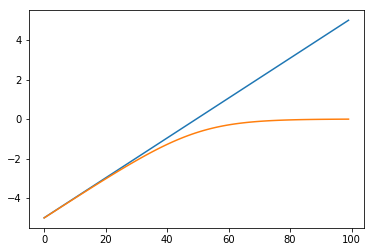

In [76]:
m = nn.LogSigmoid()
input = torch.from_numpy(np.linspace(-5,5,100))
output = m(input)
#input ,' ',output
plt.plot(input.numpy())
plt.plot(output.numpy())
plt.show()

In [61]:
m = nn.LogSigmoid()
input = torch.randn(2, 3)
output = m(input)
input ,' ',output

(tensor([[ 0.0508,  1.7007,  0.5423],
         [-1.7756,  1.8938, -0.6140]]),
 ' ',
 tensor([[-0.6681, -0.1677, -0.4583],
         [-1.9321, -0.1402, -1.0466]]))

* 1.2.2. $\text{LogSoftmax}(x_{i}) = \log\left(\frac{\exp(x_i) }{ \sum_j \exp(x_j)} \right)$

Applies the `Log(Softmax(x))` function to an n-dimensional input Tensor.
The LogSoftmax formulation can be simplified as

In [62]:
m = nn.LogSoftmax(dim=1)
output = m(input)
input ,' ',output

(tensor([[ 0.0508,  1.7007,  0.5423],
         [-1.7756,  1.8938, -0.6140]]),
 ' ',
 tensor([[-2.0594, -0.4095, -1.5679],
         [-3.7710, -0.1016, -2.6094]]))

### 1.2损失函数

* [loss functin](https://blog.csdn.net/zhangxb35/article/details/72464152)
* [loss 2](http://www.cnblogs.com/pinard/p/6437495.html)

### 1.1 nn.BCEWithLogitsLoss
        his loss combines a `Sigmoid` layer and the `BCELoss` in one single
        class. This version is more numerically stable than using a plain `Sigmoid`
        followed by a `BCELoss` as, by combining the operations into one layer,
        we take advantage of the log-sum-exp trick for numerical stability.


$\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad$

$l_n = - w_n \left[ t_n \cdot \log \sigma(x_n)+ (1 - t_n) \cdot \log (1 - \sigma(x_n)) \right]$

In [45]:
nn.BCEWithLogitsLoss?

In [40]:
    >>> loss = nn.BCEWithLogitsLoss()
    >>> input = torch.randn(2,3)
    >>> target = torch.tensor([[0,2,1],[1,0,1]]).float()
    >>> output = loss(input, target)
    

In [41]:
input,target,output

(tensor([[ 0.5466,  1.1683,  0.9099],
         [ 0.8260,  0.0118,  0.0110]]), tensor([[ 0.,  2.,  1.],
         [ 1.,  0.,  1.]]), tensor(0.3656))

### 1.2 BCELoss
        二分类用的交叉熵，用的时候需要在该层前面加上 Sigmoid 函数

   $\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad$
   
   $l_n = - w_n \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]$

Creates a criterion that measures the Binary Cross Entropy
between the target and the output

In [83]:
    >>> m = nn.Sigmoid()
    >>> loss = nn.BCELoss()
    >>> input = torch.randn(3, requires_grad=True)
    >>> target = torch.empty(3).random_(2)
    >>> output = loss(m(input), target)

In [84]:
print(input ,'\n',target)

tensor([ 0.7340, -0.4394,  0.9255]) 
 tensor([ 1.,  1.,  1.])


### 1.3 nn.MSELoss?

Creates a criterion that measures the mean squared error between
`n` elements in the input `x` and target `y`.

$\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
    l_n = \left( x_n - y_n \right)^2$

In [22]:
    >>> loss = nn.MSELoss()
    >>> input = torch.randn(3, 5, requires_grad=True)
    >>> target = torch.randn(3, 5)
    >>> output = loss(input, target) 

In [26]:
output

tensor(1.0155)

### 1.4 MultiLabelMarginLoss
* 多分类

$\text{loss}(x, y) = \sum_{ij}\frac{\max(0, 1 - (x[y[j]] - x[i]))}{\text{x.size}(0)}$


where `i == 0` to `x.size(0)`, `j == 0` to `y.size(0)`,
:math:`y[j] \geq 0`, and :math:`i \neq y[j]` for all `i` and `j`.

`y` and `x` must have the same size.

Creates a criterion that optimizes a multi-class multi-classification
hinge loss (margin-based loss) between input `x`  (a 2D mini-batch `Tensor`)
and output `y` (which is a 2D `Tensor` of target class indices).
For each sample in the mini-batch:

In [44]:
nn.MultiLabelMarginLoss?

In [104]:
loss = torch.nn.MultiLabelMarginLoss()
x = torch.autograd.Variable(torch.FloatTensor([[0.1, 0.2, ]]))
y = torch.autograd.Variable(torch.LongTensor([[0,1]]))
loss(x, y) # will give 0.8500

tensor(0.)

In [97]:
x.size(0),y.size()

(1, torch.Size([1, 4]))

### 1.5 nn.NLLLoss

The negative log likelihood loss. It is useful to train a classification
problem with `C` classes.

If provided, the optional argument `weight` should be a 1D Tensor assigning
weight to each of the classes. This is particularly useful when you have an
unbalanced training set.

The input given through a forward call is expected to contain
log-probabilities of each class. `input` has to be a Tensor of size either
:math:`(minibatch, C)` or :math:`(minibatch, C, d_1, d_2, ..., d_K)`
with :math:`K \geq 2` for the `K`-dimensional case (described later).

Obtaining log-probabilities in a neural network is easily achieved by
adding a  `LogSoftmax`  layer in the last layer of your network.
You may use `CrossEntropyLoss` instead, if you prefer not to add an extra
layer.

$\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad$

$l_n = - w_{y_n} x_{n,y_n}, \quad$

$w_{c} = \text{weight}[c] \cdot \mathbb{1}\{c \not= \text{ignore_index}\}$

In [61]:
    >>> m = nn.LogSoftmax()
    >>> loss = nn.NLLLoss()
    >>> # input is of size N x C = 3 x 5
    >>> input = torch.randn(3, 5, requires_grad=True)
    >>> # each element in target has to have 0 <= value < C
    >>> target = torch.tensor([1, 0, 4])
    >>> output = loss(m(input), target)

F:\app\anaconda\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


In [65]:
input,target

(tensor([[ 0.0554,  0.5019,  0.3709, -0.7303, -2.8850],
         [ 0.4194, -0.3108,  1.0556,  1.0694,  0.3742],
         [ 1.4532,  1.4057, -1.2860, -0.6946,  0.1770]]), tensor([ 1,  0,  4]))

In [66]:
output

tensor(1.6779)

### 1.6 cross

In [55]:
nn.CrossEntropyLoss?

This criterion combines :func:`nn.LogSoftmax` and :func:`nn.NLLLoss` in one single class.

It is useful when training a classification problem with `C` classes.
If provided, the optional argument :attr:`weight` should be a 1D `Tensor`
assigning weight to each of the classes.
This is particularly useful when you have an unbalanced training set.

The `input` is expected to contain scores for each class.

`input` has to be a Tensor of size either :math:`(minibatch, C)` or
:math:`(minibatch, C, d_1, d_2, ..., d_K)`
with :math:`K \geq 2` for the `K`-dimensional case (described later).

This criterion expects a class index (0 to `C-1`) as the
`target` for each value of a 1D tensor of size `minibatch`

The loss can be described as:

.. math::
    $\text{loss}(x, class) = -\log\left(\frac{\exp(x[class])}{\sum_j \exp(x[j])}\right)
                   = -x[class] + \log\left(\sum_j \exp(x[j])\right)$

or in the case of the `weight` argument being specified:

.. math::
   $ \text{loss}(x, class) = weight[class] \left(-x[class] + \log\left(\sum_j \exp(x[j])\right)\right)$

In [53]:
    >>> loss = nn.CrossEntropyLoss()
    >>> input = torch.randn(3, 5, requires_grad=True)
    >>> target = torch.empty(3, dtype=torch.long).random_(5)
    >>> output = loss(input, target)

In [54]:
input,target,output

(tensor([[ 1.1955, -0.0964,  0.1848, -0.5693,  0.9420],
         [ 0.4138,  2.0289, -1.7637, -1.0270, -2.6222],
         [-0.9842,  1.5360,  0.6006, -0.0826, -0.3849]]),
 tensor([ 4,  1,  4]),
 tensor(1.3225))